# Using real world data

Welcome! So far we have worked exclusively with generated data. This time you will be using the [Daily Minimum Temperatures in Melbourne](https://github.com/jbrownlee/Datasets/blob/master/daily-min-temperatures.csv) dataset which contains data of the daily minimum temperatures recorded in Melbourne from 1981 to 1990. In addition to be using Tensorflow's layers for processing sequence data such as Recurrent layers or LSTMs we will also use Convolutional layers to improve the model's performance.

Let's get started!

In [1]:
import csv
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass
from absl import logging
logging.set_verbosity(logging.ERROR)

In [2]:
TEMPERATURES_CSV = './data/daily-min-temperatures.csv'

with open(TEMPERATURES_CSV, 'r') as csvfile:
    print(f"Header looks like this:\n\n{csvfile.readline()}")    
    print(f"First data point looks like this:\n\n{csvfile.readline()}")
    print(f"Second data point looks like this:\n\n{csvfile.readline()}")

Header looks like this:

"Date","Temp"

First data point looks like this:

"1981-01-01",20.7

Second data point looks like this:

"1981-01-02",17.9



As we can see, each data point is composed of the date and the recorded minimum temperature for that date.


In the first exercise we will code a function to read the data from the csv but for now run the next cell to load a helper function to plot the time series.

In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

## Parsing the raw data
Now we need to read the data from the csv file. To do so, complete the `parse_data_from_file` function.

In [4]:
def parse_data_from_file(filename):
    
    times = []
    temperatures = []

    with open(filename) as csvfile:
        
        
        reader = csv.reader(csvfile, delimiter=',')
        
        next(reader)
        
        for row in reader:
            temperature = float(row[1])
            temperatures.append(temperature)
            
        times = list(range(len(temperatures)))
        
            
    return times, temperatures

The next cell we will use your function to compute the `times` and `temperatures` and will save these as numpy arrays within the `G` dataclass. This cell will also plot the time series:

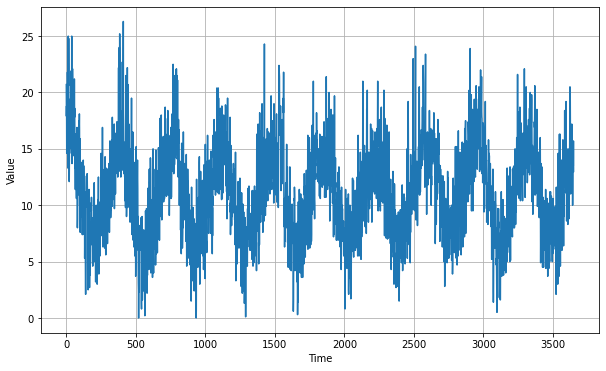

In [5]:
# Test your function and save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    TEMPERATURES_CSV = './data/daily-min-temperatures.csv'
    times, temperatures = parse_data_from_file(TEMPERATURES_CSV)
    TIME = np.array(times)
    SERIES = np.array(temperatures)
    SPLIT_TIME = 2500
    WINDOW_SIZE = 64
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000


plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

## Processing the data

Since we already coded the `train_val_split` and `windowed_dataset` functions during past week's assignments, this time they are provided for us:

In [7]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid


# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [8]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds


# Apply the transformation to the training set
train_set = windowed_dataset(series_train, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)

## Defining the model architecture

Now that we have a function that will process the data before it is fed into our neural network for training, it is time to define our layer architecture. Just as in last week's assignment we will do the layer definition and compilation in two separate steps. Begin by completing the `create_uncompiled_model` function below.

In [13]:
def create_uncompiled_model():

    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, 
                               padding="causal", activation="relu", 
                               input_shape=[None, 1]),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(30, activation="relu"),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(1)
    ]) 
    

    return model

We can test your model with the code below. If we get an error, it's likely that our model is returning a sequence. We can 
indeed use an LSTM with `return_sequences=True` but we have to feed it into another layer that generates a single prediction. We can review the lectures or the previous ungraded labs to see how that is done.

In [14]:
# Test your uncompiled model

# Create an instance of the model
uncompiled_model = create_uncompiled_model()

# Get one batch of the training set(X = input, y = label)
for X, y in train_set.take(1):
    
    # Generate a prediction
    print(f'Testing model prediction with input of shape {X.shape}...')
    y_pred = uncompiled_model.predict(X)
    
# Compare the shape of the prediction and the label y (remove dimensions of size 1)
y_pred_shape = y_pred.squeeze().shape

assert y_pred_shape == y.shape, (f'Squeezed predicted y shape = {y_pred_shape} '
                                           f'whereas actual y shape = {y.shape}.')

print("Your current architecture is compatible with the windowed dataset! :)")

Testing model prediction with input of shape (32, 64)...
Your current architecture is compatible with the windowed dataset! :)


## Adjusting the learning rate

We can leverage Tensorflow's callbacks to dynamically vary the learning rate before doing the actual training. This can be helpful in finding what value works best with our model. Note that this is only one way of finding the best learning rate. There are other techniques for hyperparameter optimization also.

In [15]:
def adjust_learning_rate(dataset):
    
    model = create_uncompiled_model()
    
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))
    
    
    # Select your optimizer
    optimizer = tf.keras.optimizers.Adam()
    
    # Compile the model passing in the appropriate loss
    model.compile(loss='mse',
                  optimizer=optimizer, 
                  metrics=["mae"]) 
    
    
    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])
    
    return history

In [16]:
# Run the training with dynamic LR
lr_history = adjust_learning_rate(train_set)

Epoch 1/100
77/77 [==============================] - 11s 101ms/step - loss: 105.8902 - mae: 9.4614 - lr: 1.0000e-04
Epoch 2/100
77/77 [==============================] - 6s 77ms/step - loss: 42.3044 - mae: 5.3664 - lr: 1.1220e-04
Epoch 3/100
77/77 [==============================] - 6s 76ms/step - loss: 17.1856 - mae: 3.2704 - lr: 1.2589e-04
Epoch 4/100
77/77 [==============================] - 6s 74ms/step - loss: 12.7509 - mae: 2.7803 - lr: 1.4125e-04
Epoch 5/100
77/77 [==============================] - 6s 76ms/step - loss: 9.4194 - mae: 2.3750 - lr: 1.5849e-04
Epoch 6/100
77/77 [==============================] - 6s 77ms/step - loss: 8.6793 - mae: 2.2977 - lr: 1.7783e-04
Epoch 7/100
77/77 [==============================] - 6s 75ms/step - loss: 8.3537 - mae: 2.2521 - lr: 1.9953e-04
Epoch 8/100
77/77 [==============================] - 6s 76ms/step - loss: 8.0330 - mae: 2.2222 - lr: 2.2387e-04
Epoch 9/100
77/77 [==============================] - 6s 74ms/step - loss: 7.8655 - mae: 2.1902 - 

(0.0001, 10.0, 0.0, 10.0)

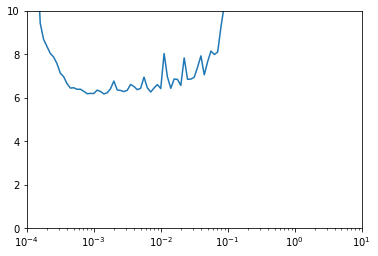

In [17]:
plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
plt.axis([1e-4, 10, 0, 10])

## Compiling the model
Now that we have trained the model while varying the learning rate, it is time to do the actual training that will be used to forecast the time series. For this complete the `create_model` function below.

Notice that we are reusing the architecture you defined in the `create_uncompiled_model` earlier. Now we only need to compile this model using the appropriate loss, optimizer (and learning rate).

In [20]:
def create_model():

    
    model = create_uncompiled_model()


    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    
    model.compile(loss="mse",
                  optimizer=optimizer,
                  metrics=["mae"])  
    


    return model

In [21]:
# Save an instance of the model
model = create_model()

# Train it
history = model.fit(train_set, epochs=50)

Epoch 1/50
77/77 [==============================] - 10s 99ms/step - loss: 113.7539 - mae: 9.8927
Epoch 2/50
77/77 [==============================] - 6s 75ms/step - loss: 69.9469 - mae: 7.3919
Epoch 3/50
77/77 [==============================] - 6s 74ms/step - loss: 34.2500 - mae: 4.7659
Epoch 4/50
77/77 [==============================] - 6s 77ms/step - loss: 19.4532 - mae: 3.4872
Epoch 5/50
77/77 [==============================] - 6s 76ms/step - loss: 16.2611 - mae: 3.1999
Epoch 6/50
77/77 [==============================] - 6s 76ms/step - loss: 14.3723 - mae: 2.9749
Epoch 7/50
77/77 [==============================] - 6s 76ms/step - loss: 11.0931 - mae: 2.5748
Epoch 8/50
77/77 [==============================] - 6s 75ms/step - loss: 9.7321 - mae: 2.4203
Epoch 9/50
77/77 [==============================] - 6s 75ms/step - loss: 8.9909 - mae: 2.3439
Epoch 10/50
77/77 [==============================] - 6s 73ms/step - loss: 8.5421 - mae: 2.2877
Epoch 11/50
77/77 [==============================]

## Evaluating the forecast

Now it is time to evaluate the performance of the forecast. For this we can use the `compute_metrics` function that we coded in a previous assignment:

In [22]:
def compute_metrics(true_series, forecast):
    
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

At this point only the model that will perform the forecast is ready but we still need to compute the actual forecast.



In [23]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

Now compute the actual forecast:

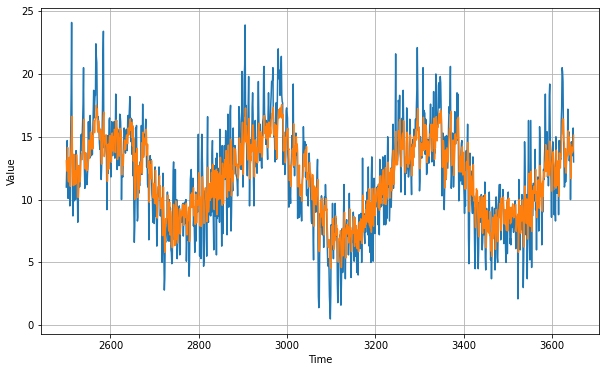

In [24]:
# Compute the forecast for all the series
rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

# Plot the forecast
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

In [25]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 5.17, mae: 1.78 for forecast


In [26]:
# Save your model in the SavedModel format
model.save('saved_model/my_model')

# Compress the directory using tar
! tar -czvf saved_model.tar.gz saved_model/

INFO:tensorflow:Assets written to: saved_model/my_model/assets


INFO:tensorflow:Assets written to: saved_model/my_model/assets


saved_model/
saved_model/my_model/
saved_model/my_model/keras_metadata.pb
saved_model/my_model/variables/
saved_model/my_model/variables/variables.data-00000-of-00001
saved_model/my_model/variables/variables.index
saved_model/my_model/saved_model.pb
saved_model/my_model/assets/
